In [17]:
# Importando bibliotecas
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Importando bibliotecas úteis para a rede
from torch.utils.data import DataLoader
from torchsummary import summary
import torchvision.transforms as transforms
import torchvision.utils as torch_utils

# Importando TravNet e seu dataset
import sys

sys.path.append('../src')

from models.TravNet import TravNet
from utils.TravDataloader import TravNetDataset

## Initialization

In [2]:
class Object(object):
    pass

params = Object() # Cria um objeto para armazenar os parâmetros
# Parametros do dataset
params.data_path        = r'/home/gian/Documentos/Códigos/IC/ablation-study/data/' 
params.csv_path         = os.path.join(params.data_path, 'data.csv')
params.preproc          = True  # Vertical flip augmentation - inverte a imagem verticalmente
params.depth_mean       = 3.5235
params.depth_std        = 10.6645

# Parametros de treino
params.seed             = 230 # Seed para o gerador de números aleatórios - como saber a melhor seed para o modelo?
params.epochs           = 50
params.batch_size       = 16
params.learning_rate    = 1e-4
params.weight_decay     = 1e-5

# Parametros do modelo 
params.pretrained = True
params.load_network_path = None 
params.input_size       = (424, 240)
params.output_size      = (424, 240)
params.output_channels  = 1
params.bottleneck_dim   = 256

In [3]:
torch.manual_seed(params.seed) # Passa a seed para a CPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(params.seed) # Caso disponível, passa a seed para a GPU

# Selecionar GPU ou CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [4]:
net = TravNet(params) # Instancia um objeto da classe ResnetDepthUnet
# summary(net,(3, 424, 240)) # Mostra um resumo da rede

# Usado para carregar um modelo salvo
if params.load_network_path is not None:
    print('Loading saved network from {}'.format(params.load_network_path))
    net.load_state_dict(torch.load(params.load_network_path))

print("Let's use", torch.cuda.device_count(), "GPUs!") # Verifica se há mais de uma GPU disponível
net = torch.nn.DataParallel(net).to(device) # Paraleliza para usar mais de uma GPU

Let's use 1 GPUs!


In [5]:
# Inicializa um tensor de teste
test = net(torch.rand([2, 3, params.input_size[1], params.input_size[0]]).to(device), torch.rand([2, 1, params.input_size[1], params.input_size[0]]).to(device)) 
print('test.shape:', test.shape)

test.shape: torch.Size([2, 1, 240, 424])


In [7]:
# Transformações para o dataset
transform = transforms.Compose([
            transforms.ToPILImage(), # Converte o tensor para uma imagem PIL
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Aplica valores aleatórios de brilho, contraste, saturação e matiz
            transforms.ToTensor(), # Converte a imagem PIL para um tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normaliza o tensor (média e desvio padrão)
            ])

dataset = TravNetDataset(params, transform)

# Divide o dataset em treino e validação 
train_size, val_size = int(0.8*len(dataset)), np.ceil(0.2*len(dataset)).astype('int')
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size]) # Separa os dados de acordo com os tamanhos estabelecidos e embaralha

train_loader    = DataLoader(train_dataset, batch_size=params.batch_size, shuffle=True, num_workers=2)
test_loader     = DataLoader(val_dataset, batch_size=params.batch_size, shuffle=True, num_workers=2)

# Informações sobre o dataset
print('Total loaded %d images' % len(dataset))
print('Loaded %d train images' % train_size)
print('Loaded %d valid images' % val_size)

Initializing dataset
Max score: 24.567
Min score: 0.0
Depth mean: 3.438056670303481
Depth std: 10.458746256918245
Total loaded 16558 images
Loaded 13246 train images
Loaded 3312 valid images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


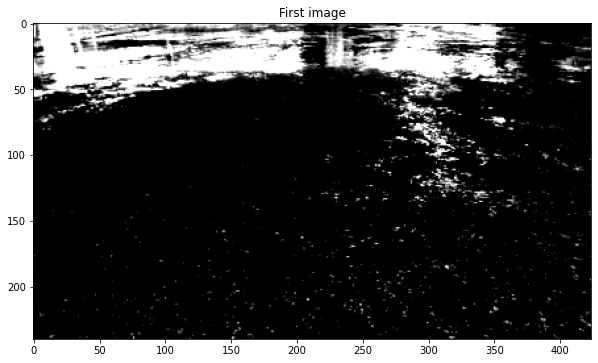

In [24]:
# Exemplo da primeira imagem do dataset
data = train_dataset[0]

first_image = data[0][0]
first_image = torch_utils.make_grid(first_image)

plt.figure(figsize=(10, 10))
plt.imshow(first_image.permute(1, 2, 0))
plt.title('First image')
plt.show()

## Set up training tools

In [ ]:
criterion = torch.nn.L1Loss(reduction='none') # Perda L1 (erro absoluto médio)
optimizer = torch.optim.Adam(net.parameters(), lr=params.learning_rate, weight_decay=params.weight_decay) # Verificar o melhor otimizador para o modelo
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True) # Reduz a taxa de aprendizado quando a perda não melhora

In [ ]:
best_val_loss = np.inf # Melhor perda de validação
train_loss_list = [] # Lista para armazenar as perdas de treino
val_loss_list = [] # Lista para armazenar as perdas de validação

accuracy_list = [] # Lista para armazenar as acurácias
predc_list = [] # Lista para armazenar as predições

# Treinamento
for epoch in range(params.epochs):
    net.train() # Modo de treino
    train_loss = 0.0 # Setando a perda para 0 a cada época

    # 'for' passando por cada imagem e cada dado do dataset
    for i, data in enumerate(train_loader):
        data = (item.to(device).type(torch.float32) for item in data) # Passa os dados para a GPU
        color_img, depth_img, path_img, mu_img, nu_img, weight = data # Separa os dados em imagens e pesos

        # Forward pass
        pred = net(color_img, depth_img)
        label = mu_img

        loss = weight*criterion(pred*path_img, label) # Calcula a perda
        loss = torch.mean(loss)
        optimizer.zero_grad() # Zera os gradientes
        loss.backward() # Backpropagation
        optimizer.step() # Atualiza os pesos com o otimizador

        train_loss += loss.item() # Somando a perda de cada batch
    
    # Atualiza a taxa de aprendizado
    scheduler.step()

    train_loss /= len(train_loader) # Calcula a perda média
    train_loss_list.append(train_loss) # Adiciona a perda média na lista de perdas de treino
        
    # Apresenta a perda de treino a cada 10 épocas
    if (epoch) % 10 == 0:
        outstring = 'Epoch [%d/%d], Loss: ' % (epoch+1, params.epochs)
        print(outstring, train_loss)
        print('Learning Rate for this epoch: {}'.format(optimizer.param_groups[0]['lr']))
    
    # Testando o modelo 
    with torch.no_grad():
        net.eval() # Modo de validação

        val_loss = 0.0 # Setando a perda para 0 a cada época
        correct = 0
        total = 0

        for i, data in enumerate(test_loader):
            data = (item.to(device).type(torch.float32) for item in data)
            color_img, depth_img, path_img, mu_img, nu_img, weight = data

            pred = net(color_img, depth_img)
            label = mu_img

            loss = weight*criterion(pred*path_img, label)
            loss = torch.mean(loss)

            val_loss += loss.item()

            # Calcula a acurácia
            _, preds = torch.max(pred, 1)
            correct += torch.sum(preds == label.data)
            total += label.size(0)

        val_loss /= len(test_loader)
        val_loss_list.append(val_loss)

        accuracy = 100 * correct / total
        accuracy_list.append(accuracy)
        print("Precisão do modelo: ", accuracy)

    # Apresenta a perda de validação
    if (epoch + 1) % 5 == 0:
        plt.figure(figsize = (14,14))
        plt.subplot(1, 3, 1)
        plt.imshow(color_img[0].permute(1, 2, 0).cpu().numpy())
        plt.subplot(1, 3, 2)
        plt.imshow(255*pred[0,0,:,:].detach().cpu().numpy(), vmin=0, vmax=255)
        plt.show(block=False)
    
    # Salva o modelo com a melhor perda de validação
    if best_val_loss > val_loss:
        best_val_loss = val_loss
        print('Updating best validation loss: %.5f' % best_val_loss)
        torch.save(net.module.state_dict(),'checkpoints/best_predictor_depth.pth')
        
    torch.save(net.module.state_dict(),'checkpoints/predictor_depth.pth')
